In [53]:
import numpy as np 
import pandas as pd 

import json
import time
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import explained_variance_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score,accuracy_score
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import itertools

#from mpl_toolkits.basemap import Basemap

import gc
import os
print(os.listdir("."))

['.DS_Store', '.ipynb_checkpoints', 'a.out', 'Assignment-1.pdf', 'ch.cpp', 'electricity-demand-prediction.ipynb', 'input']


In [54]:
in_file_name = "Home1_yr1.csv"
out_file_name = "home1_out.csv"

In [55]:
column_names = ['load_demand']
house_data = pd.read_csv("./input/" + in_file_name, low_memory=False, nrows=None, names=column_names)
house_data.shape

(35040, 1)

In [56]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 1 columns):
load_demand    35040 non-null float64
dtypes: float64(1)
memory usage: 273.8 KB


In [57]:
house_data.describe()

,load_demand
count,35040.000000
mean,1.327208
std,1.399019
min,0.015124
25%,0.315678
50%,0.722875
75%,1.988425
max,15.500000


In [58]:

epochTime = 1417392000

def get_time_stamp(row):
    global epochTime
    epochTime+=900
    return pd.to_datetime(epochTime,unit='s')

house_data['time_stamp'] = house_data.apply (lambda row: get_time_stamp(row),axis=1)


In [59]:
house_data.head(10)

,load_demand,time_stamp
0,0.65018,2014-12-01 00:15:00
1,1.45400,2014-12-01 00:30:00
2,0.72971,2014-12-01 00:45:00
3,3.10750,2014-12-01 01:00:00
4,0.63572,2014-12-01 01:15:00
5,0.69720,2014-12-01 01:30:00
6,1.50610,2014-12-01 01:45:00
7,0.85858,2014-12-01 02:00:00
8,1.61320,2014-12-01 02:15:00
9,0.66075,2014-12-01 02:30:00


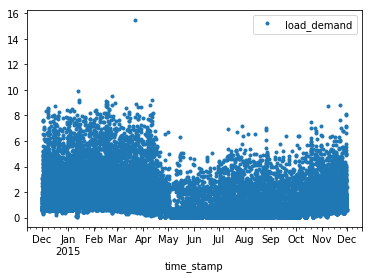

In [60]:
house_data.plot('time_stamp', 'load_demand', style=".")

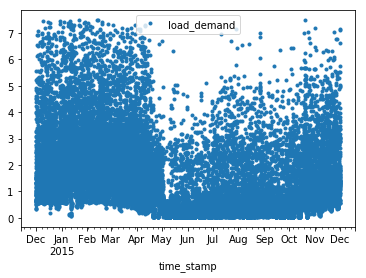

In [61]:
mean = house_data.loc[house_data['load_demand']<7.5, 'load_demand'].mean()
house_data["load_demand"] = np.where(house_data["load_demand"] >=7.5, mean, house_data['load_demand'])
house_data.plot('time_stamp', 'load_demand', style=".")

In [62]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-12-01', end='2015-11-30').to_pydatetime()

#get hour:minute format
def hour_minute(row_data):
    return (row_data.time_stamp.hour) #* 100 + (row_data.pickup_datetime.minute)

#get day_of_week format
def day_of_week(row_data):
    return (row_data.time_stamp.weekday())

def check_holiday(row_data):
    strip_date = datetime.datetime.strptime((str(row_data.time_stamp)[:10] ),'%Y-%m-%d')
    return 1 if strip_date in holidays else 0

#get month format
def get_month(row_data):
    return (row_data.time_stamp.month)

house_data['time_of_day'] = house_data.apply(lambda row: hour_minute(row), axis=1)
house_data['day_of_week'] = house_data.apply(lambda row: day_of_week(row), axis=1)
house_data['holiday'] = house_data.apply(lambda row: check_holiday(row), axis=1)
house_data['month_of_year'] = house_data.apply(lambda row: get_month(row), axis=1)
house_data['slot'] = np.array([i for i in range(1,len(house_data)+1)]).reshape(-1, 1)
house_data_copy = house_data.copy()
#del house_data['time_stamp']

house_data.head(10)

,load_demand,time_stamp,time_of_day,day_of_week,holiday,month_of_year,slot
0,0.65018,2014-12-01 00:15:00,0,0,0,12,1
1,1.45400,2014-12-01 00:30:00,0,0,0,12,2
2,0.72971,2014-12-01 00:45:00,0,0,0,12,3
3,3.10750,2014-12-01 01:00:00,1,0,0,12,4
4,0.63572,2014-12-01 01:15:00,1,0,0,12,5
5,0.69720,2014-12-01 01:30:00,1,0,0,12,6
6,1.50610,2014-12-01 01:45:00,1,0,0,12,7
7,0.85858,2014-12-01 02:00:00,2,0,0,12,8
8,1.61320,2014-12-01 02:15:00,2,0,0,12,9
9,0.66075,2014-12-01 02:30:00,2,0,0,12,10


In [63]:
#get day_of_week format

#house_data.time_stamp[0].month

In [64]:
#Naive model

def Naive_Model(X):
    return X[-96:]

def Mean_Absolute_Error(x, y):
    return sum([abs(x[i] - y[i]) for i in range(len(y))])/(len(y) * 1.0)

day_value = 364
interval_count = day_value * 96
column = house_data.columns[0]
#print(house_data[column].values)
X_train = house_data[column].values[:interval_count]
X_test = house_data[column].values[interval_count:interval_count+96]
y = Naive_Model(X_train)
#print(X_test, y)
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(X_test, y))

Mean Absolute Error : 1.12915


In [65]:
#Linear Regression without additional features
linear_regression = LinearRegression()
final_columns = house_data.columns

linear_reg_train_X = np.array([i for i in range(1,len(X_train)+1)]).reshape(-1, 1)
linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
linear_reg_test_X = np.array([len(X_train)+i for i in range(1,len(X_test)+1)]).reshape(-1, 1)
linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(final_columns,linear_regression.coef_)])
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))


Coefficients (a,b,c,..) :  [('load_demand', -4.9933340166309106e-05)]
Mean squared error: 4.74412
Variance : -1.21204
Mean Absolute Error : 1.61194


In [66]:
#Linear Regression with additional features
day_value = 364
interval_count = day_value * 96
column = house_data.columns[0]
linear_regression = LinearRegression()
final_columns = house_data.columns[2:]

linear_reg_train_X = house_data[final_columns][:interval_count]
linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
linear_reg_test_X = house_data[final_columns][interval_count:interval_count+96]
linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(final_columns,linear_regression.coef_)])
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))



Coefficients (a,b,c,..) :  [('time_of_day', 0.043335762933459185), ('day_of_week', 0.00032324780398984874), ('holiday', 0.1423752721405455), ('month_of_year', -0.026550653182735626), ('slot', -4.5255769724479914e-05)]
Mean squared error: 4.70126
Variance : -1.19205
Mean Absolute Error : 1.67678


In [67]:
from fbprophet import Prophet

df = pd.DataFrame({"ds":house_data["time_stamp"].values})
df['y'] = house_data['load_demand']
df.reset_index(drop=False,inplace=True)

day_value = 364
interval_count = day_value * 96

fp_train_X = df[:interval_count]
fp_train_Y = np.array(df['y'].values[:interval_count])
fp_test_X = df[interval_count:interval_count+96]
fp_test_Y = np.array(df['y'].values[interval_count:interval_count+96])

# creating holiday list
fed_holiday = pd.DataFrame({"ds":house_data["time_stamp"].values})
fed_holiday['holiday'] = house_data['holiday']
fed_holiday = fed_holiday[fed_holiday['holiday'] == 1]
fed_holiday['holiday'] = fed_holiday.apply(lambda row: 'holiday', axis=1)

m = Prophet(yearly_seasonality=True, holidays=fed_holiday)
m.fit(fp_train_X)

future = m.make_future_dataframe(periods=60*24, freq='min')
future = future[::-15][:96]
future = future[::-1]
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

result_y = m.predict(future)

print("Mean squared error: %.5f" % mean_squared_error(fp_test_Y, result_y['yhat']))
print('Variance : %.5f' % r2_score(fp_test_Y, result_y['yhat']))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(fp_test_Y, result_y['yhat']))

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Mean squared error: 1.94899
Variance : 0.09124
Mean Absolute Error : 0.88476


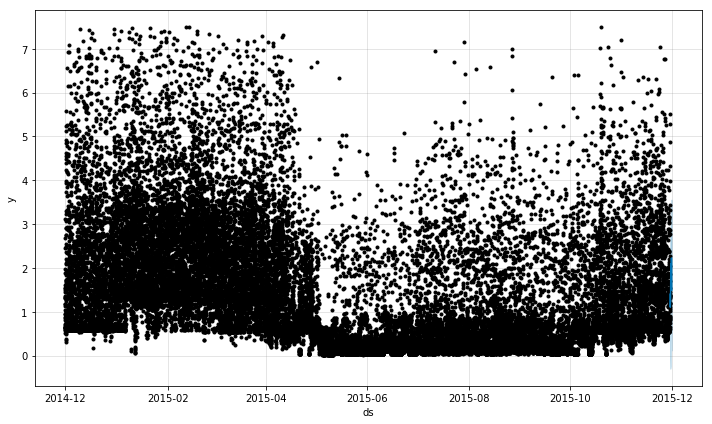

In [68]:
fig1 = m.plot(result_y)

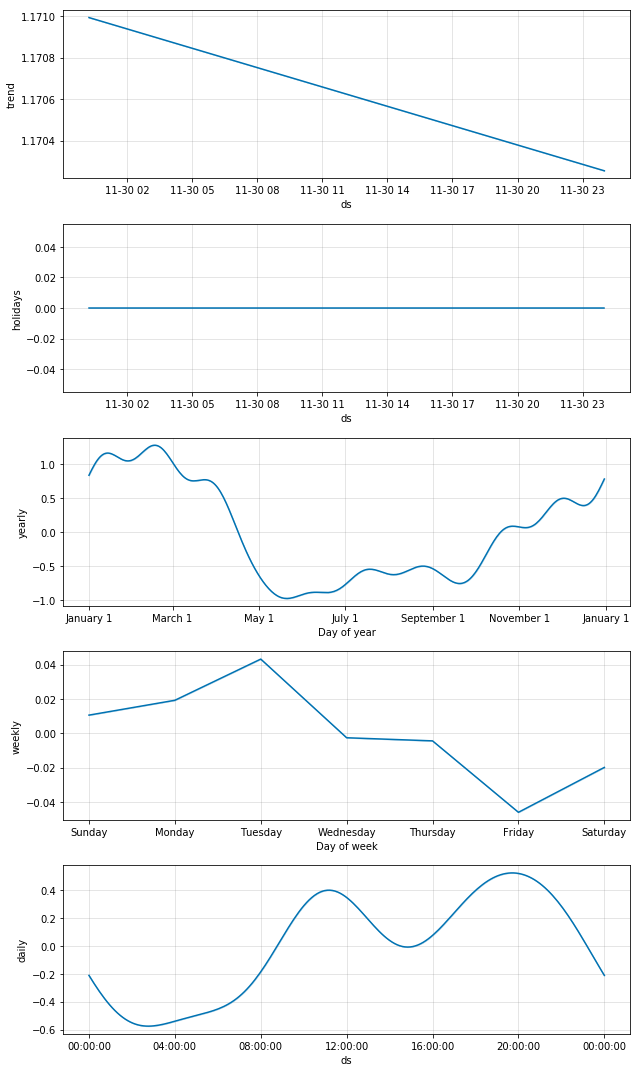

In [69]:
fig2 = m.plot_components(result_y)

In [ ]:
import warnings
import statsmodels.api as sm

p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(X_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:142778.6826717422


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1052: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:130192.91079189125
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:125146.48441460433
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:105741.45934981618
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:119434.15638058457
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:105772.20281081856
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:117943.68994769703
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:105360.80543732757


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:124201.26124245155
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:118419.15789197423
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:121710.30540172869
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:100734.19562966452
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:113588.07082319297
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:100764.94941535367
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:113529.69195275714
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:100592.79211135203
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:111196.54508351047
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:111159.88355021283
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:135321.12587862372
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:111206.21123547954
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:111162.64979753716
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:111161.87443361721
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:125279.59474051191
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:111207.98320727014
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:98999.13128306653
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:98968.983983

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

model = SARIMAX(X_train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
#model = SARIMAX(X_train, order=(1, 0, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)
linear_reg_predicted_Y = model_fit.predict(len(X_train), len(X_train)+95)
print(len(linear_reg_predicted_Y), len(X_test))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(X_test, linear_reg_predicted_Y))


In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()